In [2]:
using Plots
using LinearAlgebra
using SpecialFunctions

In [46]:
function enumerate_states(space)
    # space = (Nmax, Jz, parity)
    Nmax   = space.Nmax
    Jz     = space.Jz
    parity = space.parity
    
    states = []
    for N in parity:2:Nmax
        for l in 0:N
            if (N-l)%2 != 0
                continue
            end
            
            for ml in -l:l
                for ms in -1:2:1
                    if 2ml + ms == Jz
                        push!(states, (N=N,l=l,ml=ml,ms=ms))
                    end
                end
            end
        end
    end
    return states
end

enumerate_states (generic function with 1 method)

In [96]:
space = (Nmax = 10, Jz = 1, parity = 0)
@time enumerate_states(space)

  0.000009 seconds (42 allocations: 2.828 KiB)


36-element Array{Any,1}:
 (N = 0, l = 0, ml = 0, ms = 1)
 (N = 2, l = 0, ml = 0, ms = 1)
 (N = 2, l = 2, ml = 0, ms = 1)
 (N = 2, l = 2, ml = 1, ms = -1)
 (N = 4, l = 0, ml = 0, ms = 1)
 (N = 4, l = 2, ml = 0, ms = 1)
 (N = 4, l = 2, ml = 1, ms = -1)
 (N = 4, l = 4, ml = 0, ms = 1)
 (N = 4, l = 4, ml = 1, ms = -1)
 (N = 6, l = 0, ml = 0, ms = 1)
 (N = 6, l = 2, ml = 0, ms = 1)
 (N = 6, l = 2, ml = 1, ms = -1)
 (N = 6, l = 4, ml = 0, ms = 1)
 ⋮
 (N = 8, l = 8, ml = 1, ms = -1)
 (N = 10, l = 0, ml = 0, ms = 1)
 (N = 10, l = 2, ml = 0, ms = 1)
 (N = 10, l = 2, ml = 1, ms = -1)
 (N = 10, l = 4, ml = 0, ms = 1)
 (N = 10, l = 4, ml = 1, ms = -1)
 (N = 10, l = 6, ml = 0, ms = 1)
 (N = 10, l = 6, ml = 1, ms = -1)
 (N = 10, l = 8, ml = 0, ms = 1)
 (N = 10, l = 8, ml = 1, ms = -1)
 (N = 10, l = 10, ml = 0, ms = 1)
 (N = 10, l = 10, ml = 1, ms = -1)

### $r^2$の行列要素
3次元等方調和振動子において、$r^2$の行列要素は次式で与えられる：
$$
    \langle N'l' | r^2 | Nl \rangle 
    = \left[
    \frac{(n'-1)! (n-1)!}{\Gamma(n'+l'+1/2) \Gamma(n+l+1/2)}
    \right]^{1/2} (-1)^{n'+n} \mu! \nu! 
    \\
    \times \sum_{\sigma}
    \frac{\Gamma(p+\sigma+1)}
    {\sigma! (n'-1-\sigma)! (n-1-\sigma)! (\sigma+\mu-n'+1)! (\sigma+\nu-n+1)!}
$$
ここで、
$$
    p = \frac{1}{2} (l + l' + 3),\ \ \ \mu = p - l' - 1/2, \ \ \ \nu = p - l - 1/2
    \\
    N = 2(n-1) + l,\ \ \ N' = 2(n'-1) + l'
$$
であり、整数$\sigma$はこれを含むすべての階乗が負にならない範囲をとる。

In [4]:
function r2_matrix_element(N,l, N2,l2)
    # 行列要素 < N2 l2 | r^2 | N l > を計算する
    if abs(N-N2) > 2 || (N-N2)%2 != 0
        return 0.0
    end
    if abs(l-l2) > 2 || (l-l2)%2 != 0
        return 0.0
    end
    
    n  = div(N -l ,2) + 1
    n2 = div(N2-l2,2) + 1
    
    p = (l + l2 + 3)/2
    μ = div( l-l2,2) + 1
    ν = div(-l+l2,2) + 1
    
    
    # 定数部分の計算
    con = factorial(n2-1)*factorial(n-1)/(gamma(n2+l2+1/2)*gamma(n+l+1/2))
    con = sqrt(con)*factorial(μ)*factorial(ν)
    if (n+n2)%2 == 1
        con = -con
    end
    
    # 和の計算
    sum = 0.0
    for σ in max(0, n2-1-μ, n-1-ν):min(n2-1,n-1)
        sum += gamma(p+σ+1)/(factorial(σ)*factorial(n2-1-σ)*factorial(n-1-σ)*factorial(σ+μ-n2+1)*factorial(σ+ν-n+1))
    end
    
    return con*sum
end

r2_matrix_element (generic function with 1 method)

In [90]:
# test r2_matrix_element
function test_r2_matrix_element(Nmax, eps)
    for N = 0:Nmax
        for l in 0:N
            if (N-l)%2 != 0
                continue
            end
            n = div(N-l,2) + 1
            mat_el1 = r2_matrix_element(N,l, N,l)
            mat_el2 = N + 3/2
            @assert abs(mat_el1 - mat_el2) < eps
        end
    end

    for N = 0:Nmax
        for l in 2:N
            if (N-l)%2 != 0
                continue
            end
            n = div(N-l,2) + 1
            mat_el1 = r2_matrix_element(N,l-2, N,l)
            mat_el2 = -2*sqrt(n*(n+l-1/2))
            @assert abs(mat_el1 - mat_el2) < eps
        end
    end

    for N = 2:Nmax
        for l in 0:N-2
            if (N-l)%2 != 0
                continue
            end
            n = div(N-l,2) + 1
            mat_el1 = r2_matrix_element(N-2,l, N,l)
            mat_el2 = -sqrt((n-1)*(n+l-1/2))
            @assert abs(mat_el1 - mat_el2) < eps
        end
    end

    for N = 2:Nmax
        for l in 2:N
            if (N-l)%2 != 0
                continue
            end
            n = div(N-l,2) + 1
            mat_el1 = r2_matrix_element(N-2,l-2, N,l)
            mat_el2 = sqrt((n+l-1/2)*(n+l-3/2))
            @assert abs(mat_el1 - mat_el2) < eps
        end
    end

    for N = 2:Nmax
        for l in 0:N-4
            if (N-l)%2 != 0
                continue
            end
            n = div(N-l,2) + 1
            mat_el1 = r2_matrix_element(N-2,l+2, N,l)
            mat_el2 = sqrt((n-1)*(n-2))
            @assert abs(mat_el1 - mat_el2) < eps
        end
    end
end

Nmax = 10
eps = 1.0e-10
@time test_r2_matrix_element(Nmax, eps)

  0.070000 seconds (94.54 k allocations: 4.811 MiB)


### 球面調和関数$Y_{20}(\theta,\phi)$の行列要素
$$
    \langle l' m_l' | Y_{20} | l m_l \rangle
    = i^{l'-l} \sqrt{\frac{5}{4\pi}} \sqrt{\frac{2l+1}{2l'+1}} 
    (l m_l 2 0 | l'm_l') (l 0 2 0 | l' 0)
$$

In [6]:
function y20_matrix_element(l,ml,ms, l2,ml2,ms2)
    # 行列要素 < l2 ml2 ms2 | Y20 | l ml ms > を計算する
    if ml != ml2 || ms != ms2
        return 0.0
    end
    if abs(l-l2) > 2 && (l-l2)%2 != 0 
        return 0.0
    end
    
    mat_el = sqrt(5/(4π)) * sqrt((2l+1)/(2l2+1)) * clebsch2(l,ml,2,0,l2,ml2) * clebsch2(l,0,2,0,l2,0)
    if l != l2
        mat_el = -mat_el
    end
    
    return mat_el
end

y20_matrix_element (generic function with 1 method)

In [7]:
function clebsch(j1::Int, m1::Int, j2::Int, m2::Int, j::Int, m::Int)
    if j1 < abs(m1) || (j1-m1)%2 != 0 
        error("error in clebsch: j1 < abs(m1) or (j1-m1)%2 != 0")
    end
    if j2 < abs(m2) || (j2-m2)%2 != 0
        error("error in clebsch: j2 < abs(m2) or (j2-m2)%2 != 0")
    end
    if j < abs(m) || (j-m)%2 != 0 
        error("error in clebsch: j < abs(m) or (j-m)%2 != 0")
    end
    
    # j = |j1-j2|, |j1-j2|+1, ..., j1+j2 が成り立たなければ0を返す
    if j < abs(j1-j2) || j > j1 + j2 || (j-j1-j2)%2 != 0
        return 0.0
    end
    
    # m = m1 + m2 が成り立たなければ0を返す
    if m != m1 + m2 
        return 0.0
    end
    
    # 定数部分の計算
    #println((j+1)," ",div(j1+j2-j,2), " ", div(j1-j2+j,2), " ", div(-j1+j2+j,2), " ", div(j1+j2+j,2)+1)
    #println(div(j1+m1,2), " ", div(j1-m1,2), " ", div(j2+m2,2), " ", div(j2-m2,2), " ", div(j+m,2), " ", div(j-m,2))
    con = sqrt( (j+1) * factorial(div(j1+j2-j,2)) * factorial(div(j1-j2+j,2)) * factorial(div(-j1+j2+j,2)) / factorial(div(j1+j2+j,2)+1) )
    con *= sqrt( 1.0*factorial(div(j1+m1,2)) * factorial(div(j1-m1,2)) * factorial(div(j2+m2,2)) * factorial(div(j2-m2,2)) * factorial(div(j+m,2)) * factorial(div(j-m,2)) )
    
    # 和の計算
    sum = 0.0
    for z = div(max(0, -j+j2-m1, -j+j1+m2),2):div(min(j1+j2-j, j1-m1, j2+m2),2)
        add = 1/(factorial(z) * factorial(div(j1+j2-j,2)-z) * factorial(div(j1-m1,2)-z) * factorial(div(j2+m2,2)-z) * factorial(div(j-j2+m1,2)+z) * factorial(div(j-j1-m2,2)+z))
        if z%2 == 1
            add *= -1
        end
        sum += add
    end
    
    return con*sum
end

function clebsch2(l1::Int, ml1::Int, l2::Int, ml2::Int, l3::Int, ml3::Int)
    return clebsch(2l1, 2ml1, 2l2, 2ml2, 2l3, 2ml3)
end

clebsch2 (generic function with 1 method)

In [39]:
function make_deformation_ham(states)
    # 行列 < N2 l2 ml2 ms2 | r^2 Y20 | N l ml ms > を作る
    # states[i] = (N, l, ml, ms)
    
    n_states = length(states)
    def_ham = zeros(Float64, n_states, n_states)
    
    for i in 1:n_states
        N2  = states[i].N
        l2  = states[i].l
        ml2 = states[i].ml
        ms2 = states[i].ms
        for j in 1:n_states
            N  = states[j].N
            l  = states[j].l
            ml = states[j].ml
            ms = states[j].ms
            def_ham[i,j] = r2_matrix_element(N,l, N2,l2)*y20_matrix_element(l,ml,ms, l2,ml2,ms2)
        end
    end
    
    return def_ham
end

make_deformation_ham (generic function with 1 method)

### Hamiltonian
Nilsson modelのHamiltonianは次式で与えられる：
$$
    H = \hbar \omega_{0}(\delta) \left(-\frac{1}{2}\nabla^2 + \frac{1}{2}r^2\right)
    + C\vec{l}\cdot\vec{s} + D\left(\vec{l}^2 - \langle \vec{l}^2 \rangle_{N}\right)
    - \frac{4}{3} \sqrt{\frac{\pi}{5}} \hbar \omega_{0}(\delta)\, \delta\, r^2 Y_{20}
$$
ここで、
$$
    C = -2\kappa,\ \ \ D = -\kappa\mu,\ \ \ 
    \omega_{0}(\delta) 
    = \omega_{0}(0)\left(1 - \frac{4}{3}\delta^2 - \frac{16}{27}\delta^3\right)^{-1/6}
$$
である。

In [40]:
function make_nilsson_ham(pars, states)
    # 行列 < N2 l2 ml2 ms2 | H | N l ml ms > を作る
    # pars = (κ, μ, δ)
    # states[i] = (N, l, ml, ms)
    
    κ = pars.κ
    μ = pars.μ
    δ = pars.δ
    
    C = -2κ
    D = -κ*μ
    ω₀ = (1 - (4/3)*δ^2 - (16/27)*δ^3)^(-1/6)
    
    n_states = length(states)
    ham = zeros(Float64, n_states, n_states)
    for i in 1:n_states
        N2  = states[i].N
        l2  = states[i].l
        ml2 = states[i].ml
        ms2 = states[i].ms
        for j in 1:n_states
            N  = states[j].N
            l  = states[j].l
            ml = states[j].ml
            ms = states[j].ms
            
            #対角成分の計算
            if i == j
                ham[i,j] += ω₀*(N + 3/2) + C*ml*ms/2 + D*(l*(l+1) - N*(N+3)/2)
            end
            
            # ls力の非対角成分の計算
            if N!=N2 || l!=l2
                continue
            end
            for sign = -1:2:1
                if ml+sign==ml2 && ms==sign && ms2==-sign 
                    ham[i,j] += C*(1/2)*sqrt((l-sign*ml)*(l+sign*ml+1))
                end
            end
        end
    end
    
    def_con = -(4/3)*sqrt(π/5)*ω₀*δ
    def_ham = make_deformation_ham(states)
    
    ham .+= def_con*def_ham
    return ham
end

make_nilsson_ham (generic function with 1 method)

In [69]:
function plot_nilsson_subdiagram(space, ylims; addition=false)
    states = enumerate_states(space)
    n_states = length(states)
    
    if n_states==0
        return
    end

    κ = 0.08
    μ = 0.0
    δs_length=120
    δs = range(-0.6, 0.6, length=δs_length)

    εs = zeros(Float64, δs_length, n_states)
    for i in 1:δs_length
        pars = (κ=κ, μ=μ, δ=δs[i])
        ham = make_nilsson_ham(pars, states)
        ε = eigvals(ham)
        εs[i,:] = ε
    end
    
    # Nilsson diagramをプロット
    linecolor=:black
    size=(600,700)
    if addition
        plot!(δs, εs, xlabel="δ", ylabel="energy", ylims=ylims, legend=false, linecolor=linecolor, size=size)
    else
        plot( δs, εs, xlabel="δ", ylabel="energy", ylims=ylims, legend=false, linecolor=linecolor, size=size)
    end
    
end

plot_nilsson_subdiagram (generic function with 1 method)

  0.124592 seconds (938.08 k allocations: 41.278 MiB, 12.10% gc time)


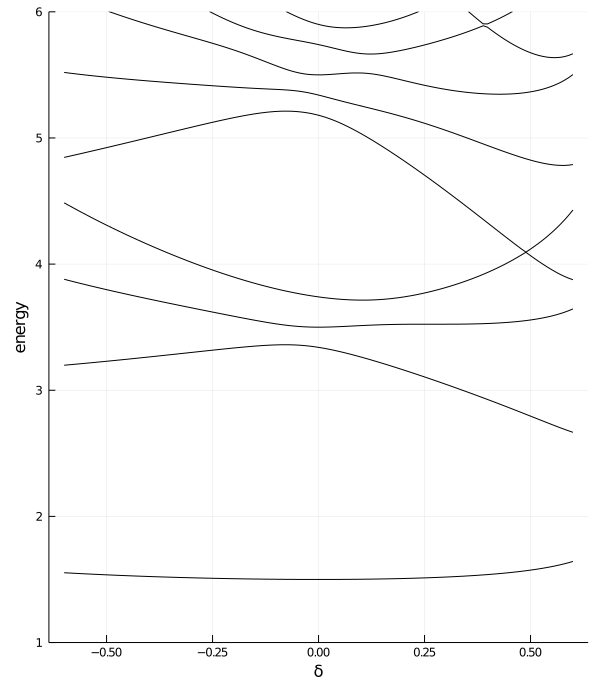

In [91]:
space = (Nmax=8, Jz=1, parity=0)
ylims = (1,6)
plot_nilsson_subdiagram(space, ylims, addition=false)

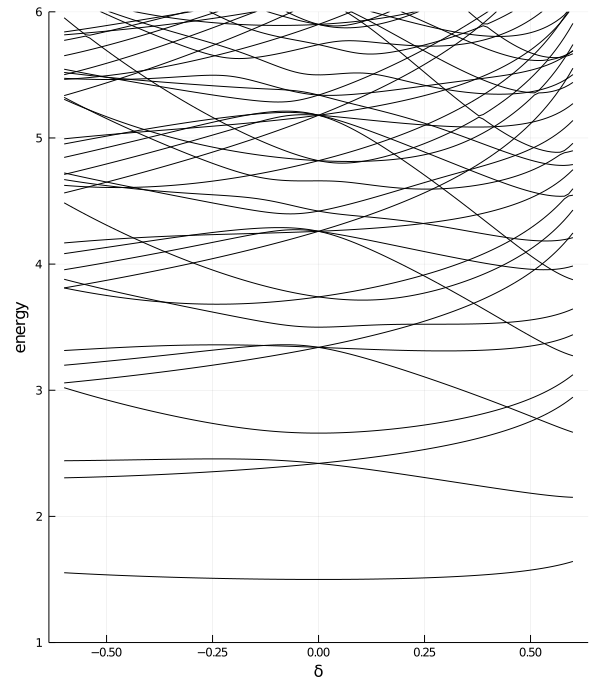

In [94]:
function plot_nilsson_diagram(Nmax, ylims)
    for Jz = 1:2:2Nmax-1
        for parity = 0:1
            space = (Nmax=Nmax, Jz=Jz, parity=parity)
            if Jz==1 && parity==0
                global p=plot_nilsson_subdiagram(space, ylims)
            else
                global p=plot_nilsson_subdiagram(space, ylims, addition=true)
            end
        end
    end
    return p
end

Nmax = 8
ylims=(1,6)
plot_nilsson_diagram(Nmax, ylims)

In [76]:
function calc_EperA(pars, n_neut, n_prot)
    @assert n_neut ≥ 0 && n_prot ≥ 0
    
    εs = []
    Nmax = 8
    for Jz = 1:2:2Nmax-1
        for parity = 0:1
            space = (Nmax=Nmax, Jz=Jz, parity=parity)
            
            states = enumerate_states(space)
            n_states = length(states)
            if n_states == 0 
                continue
            end
            
            ham = make_nilsson_ham(pars, states)
            ε = eigvals(ham)
            push!(εs, ε)
        end
    end
    εs = vcat(εs...)
    εs = sort(εs)
    return (sum(εs[1:div(n_neut,2)]) + sum(εs[1:div(n_prot,2)]))/(n_neut + n_prot)
end
            

calc_EperA (generic function with 1 method)

In [77]:
function plot_EperA(n_neut, n_prot)
    δs_length=120
    δs = range(-0.6, 0.6, length=δs_length)
    εs = zeros(Float64, δs_length)

    for i in 1:δs_length
        pars = (κ=0.08, μ=0.0, δ=δs[i])
        εs[i] = calc_EperA(pars, n_neut, n_prot)
    end
    plot(δs, εs, xlabel="δ", ylabel="E/A")
end


plot_EperA (generic function with 1 method)

  0.454877 seconds (3.88 M allocations: 179.380 MiB, 6.61% gc time)


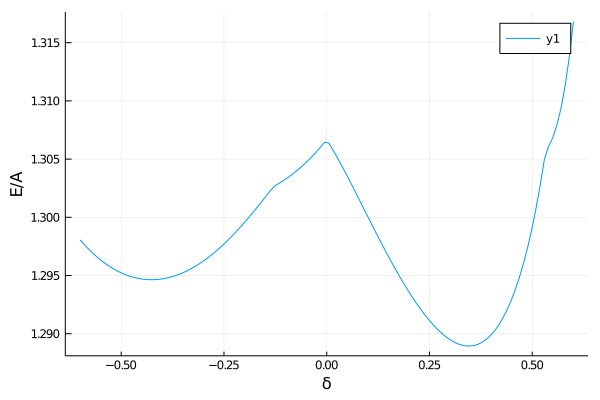

In [95]:
plot_EperA(12,12)